# <center> **Motorica SkillFactory internship test task 2023-12**

## Импорт библиотек и чтение данных

In [80]:
# работа с массивами/таблицами
import numpy as np
import pandas as pd

# визуализация
import seaborn as sns
from matplotlib import pyplot as plt

# преобразование и моделирование
import sklearn.linear_model as lm
import sklearn.metrics as m 
import sklearn.model_selection as ms
import sklearn.tree as t 
import sklearn.ensemble as ens 
import sklearn.preprocessing as pp

# чтобы предупреждения не мешали
import warnings
warnings.filterwarnings('ignore')

plt.style.use('bmh')

# для random_state
SEED = 3

In [81]:
# факторы
X_train = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')

# целевые переменные
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/sample_submission.csv')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(323, 40, 100) (32300, 2)
(54, 40, 100) (5400, 2)


## Объяснение данных

Данные с факторами представляют из себя трехмерные массивы. Чтобы выполнить задачу классификации, их нужно перевести в двумерный формат. 

Можно заметить, что число наблюдений в `X_train` - это просто число наблюдений из `y_ytain` поделенное на количество временных отметок в `X_train`. 

In [82]:
X_train.shape[0] == y_train.shape[0] / X_train.shape[2]

True

А это значит, что мы сможем **вертикально соединить** каждый двумерный массив из `X_train`, находящийся на оси времени. Таким образом мы получим таблицу, у которой размерность по оси наблюдений совпадает с целевой переменной. Для проверки этого я даже попробую установить на нее столбец с отметками из `y_train` в качестве индекса.

С `X_test` поступим также, так как там работает тот же принцип. 

## Преобразование данных

In [83]:
def tensor_to_matrix(tensor, indexer=None):
    """Функция переводит трехмерный массив в двумерный 
    путем вертикального соединения двумерных массивов на оси аппликат. 

    Args:
    ---
        tensor (`ArrayLike`): трехмерный массив
        indexer (`DataFrame`, optional): индексы, по желанию

    Returns:
    ---
        `DataFrame`: двумерный массив 
    """
    samples = []

    # перебираем двумерные массивы и заносим их в список, 
    # не забываем их транспонировать, чтобы строки и столбцы были на своих местах
    for X in tensor:
        samples.append(pd.DataFrame(X).T)
    
    # соединяем их и устанавливаем индексы
    matrix = pd.concat(samples, axis=0)
    
    if indexer is not None:
        matrix = matrix.set_index(indexer.iloc[:, 0], drop=True)
    
    return matrix


X_train_2d = tensor_to_matrix(X_train, y_train)
X_test_2d = tensor_to_matrix(X_test, y_test)

Теперь посмотрим, как выглядят получившиеся таблицы.

In [84]:
X_train_2d

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
sample-timestep,,,,,,,,,,,,,,,,,,,,,
0-0,1123.0,10.0,1450.0,64.0,34.0,1743.0,145.0,12.0,1068.0,14.0,...,1877.0,73.0,13.0,1169.0,129.0,29.0,1677.0,36.0,718.0,26.0
0-1,1125.0,7.0,1441.0,66.0,33.0,1738.0,143.0,17.0,1064.0,0.0,...,1876.0,70.0,20.0,1170.0,132.0,28.0,1673.0,28.0,730.0,25.0
0-2,1121.0,17.0,1444.0,60.0,32.0,1732.0,141.0,10.0,1065.0,14.0,...,1878.0,77.0,14.0,1169.0,130.0,30.0,1670.0,29.0,727.0,27.0
0-3,1120.0,10.0,1440.0,59.0,32.0,1730.0,143.0,6.0,1066.0,13.0,...,1876.0,68.0,13.0,1165.0,131.0,29.0,1667.0,24.0,726.0,34.0
0-4,1115.0,16.0,1437.0,51.0,30.0,1724.0,138.0,4.0,1062.0,12.0,...,1872.0,73.0,9.0,1165.0,133.0,29.0,1667.0,32.0,724.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322-95,1679.0,17.0,1826.0,36.0,26.0,2250.0,43.0,5.0,1369.0,28.0,...,1643.0,71.0,19.0,1186.0,108.0,26.0,1689.0,25.0,388.0,27.0
322-96,1673.0,4.0,1827.0,35.0,25.0,2251.0,42.0,10.0,1371.0,19.0,...,1658.0,72.0,15.0,1204.0,106.0,25.0,1690.0,32.0,388.0,27.0
322-97,1669.0,10.0,1832.0,33.0,30.0,2251.0,38.0,1.0,1369.0,18.0,...,1661.0,66.0,14.0,1203.0,107.0,27.0,1690.0,16.0,390.0,27.0


In [85]:
X_test_2d

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
sample-timestep,,,,,,,,,,,,,,,,,,,,,
323-0,1681.0,4.0,1834.0,33.0,26.0,2254.0,43.0,0.0,1376.0,27.0,...,1635.0,82.0,16.0,1204.0,108.0,25.0,1685.0,27.0,386.0,25.0
323-1,1679.0,17.0,1826.0,36.0,26.0,2250.0,43.0,5.0,1369.0,28.0,...,1643.0,71.0,19.0,1186.0,108.0,26.0,1689.0,25.0,388.0,27.0
323-2,1673.0,4.0,1827.0,35.0,25.0,2251.0,42.0,10.0,1371.0,19.0,...,1658.0,72.0,15.0,1204.0,106.0,25.0,1690.0,32.0,388.0,27.0
323-3,1669.0,10.0,1832.0,33.0,30.0,2251.0,38.0,1.0,1369.0,18.0,...,1661.0,66.0,14.0,1203.0,107.0,27.0,1690.0,16.0,390.0,27.0
323-4,1670.0,3.0,1831.0,36.0,28.0,2249.0,40.0,8.0,1368.0,18.0,...,1653.0,76.0,30.0,1207.0,107.0,26.0,1691.0,29.0,391.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376-95,1887.0,16.0,1856.0,43.0,53.0,2308.0,61.0,16.0,1444.0,24.0,...,1631.0,60.0,11.0,1166.0,120.0,28.0,1675.0,36.0,316.0,29.0
376-96,1884.0,17.0,1850.0,27.0,45.0,2304.0,61.0,7.0,1441.0,25.0,...,1641.0,69.0,3.0,1166.0,122.0,28.0,1668.0,29.0,315.0,29.0
376-97,1882.0,13.0,1843.0,37.0,51.0,2299.0,60.0,1.0,1437.0,25.0,...,1659.0,75.0,18.0,1167.0,119.0,28.0,1676.0,26.0,313.0,30.0


Замечу, что `y_test` мы не будем использовать для валидации модели, так как задача этого не предполагает. Нам нужно эту переменную создать самим и отправить на Kaggle в качестве сабмишшна. 

Поэтому для обучения воспользуемся только `y_train`, нам из него нужен только столбец с классом.

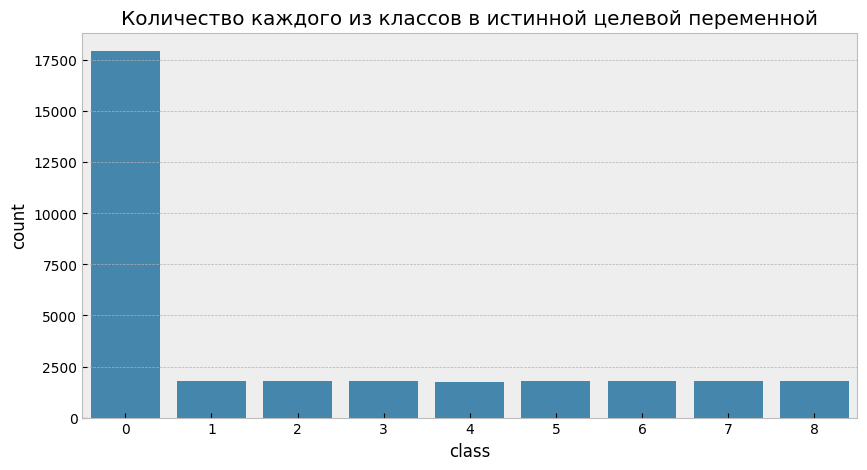

In [114]:
y_train_2d = y_train['class']

plt.figure(figsize=(10, 5))
sns.barplot(y_train_2d.value_counts())

plt.title('Количество каждого из классов в истинной целевой переменной')
plt.show()

Считаю необходимым также стандартизировать данные, поскольку так модели будет проще обучаться. 

In [87]:
scaler = pp.StandardScaler()

# обучим скейлер на всех данных, для лучшей точности
X_full = pd.concat([X_train_2d, X_test_2d], axis=0)
scaler.fit(X_full)

X_train_2d = scaler.transform(X_train_2d)
X_test_2d = scaler.transform(X_test_2d)

Посмотрим, как они выглядят теперь.

In [88]:
X_train_2d

array([[ 0.15634284, -0.06950633,  0.40318652, ...,  1.80272219,
         1.17222523,  0.51985332],
       [ 0.1629748 , -0.5294926 ,  0.3829491 , ...,  0.3918347 ,
         1.24334451,  0.27257897],
       [ 0.14971088,  1.00379499,  0.38969491, ...,  0.56819564,
         1.22556469,  0.76712766],
       ...,
       [ 1.96686808, -0.06950633,  1.26215239, ..., -1.72449653,
        -0.7717017 ,  0.76712766],
       [ 1.97018407, -1.14280764,  1.25990379, ...,  0.56819564,
        -0.7657751 , -4.92018227],
       [ 1.95692014, -0.37616384,  1.25540658, ..., -0.66633091,
        -0.72428885,  0.51985332]])

In [89]:
X_test_2d

array([[ 2.00665985, -0.98947888,  1.26664959, ...,  0.21547377,
        -0.79540813,  0.27257897],
       [ 2.00002789,  1.00379499,  1.24866078, ..., -0.1372481 ,
        -0.78355492,  0.76712766],
       [ 1.98013201, -0.98947888,  1.25090938, ...,  1.09727845,
        -0.78355492,  0.76712766],
       ...,
       [ 2.67317189,  0.39047995,  1.28688701, ...,  0.03911283,
        -1.22805041,  1.50895069],
       [ 2.68643581,  0.54380871,  1.26889819, ...,  0.21547377,
        -1.19841737,  2.00349938],
       [ 2.63006414,  0.23715119,  1.23516917, ...,  0.03911283,
        -1.21027059,  1.01440201]])

## Разработка модели

Сначала рассмотрим самые простые модели, а затем постепенно будем переходить к более сложным. Для успешного обучения и оптимизации модели я создам функцию, которая делает данный процесс автоматическим.

In [90]:
def optimise_model_cv(model, 
                      params,
                      X_train=X_train_2d, 
                      y_train=y_train_2d, 
                      scoring='f1_weighted'):
    """Функция автоматизирует процесс обучения модели и оптимизации ее гиперпараметров с кросс-валидацией.
    
    Алгоритм состоит из 3 шагов:
    
        1. Обучить модель с параметрами по умолчанию и вычислить метрики модели на тренировочной и валидационной выборках.
        2. Подобрать гиперпараметры по сетке и выделить 
        3. Обучить оптимизованную модель и сравнить ее метрики с метриками первичной модели.
        
    В качестве метрики выбрана `'f1_weighted'`, так как она учитывает несбалансированность классов. 

    По мере прохождения каждого из шагов на экран выводятся значения метрик и словарь подобранных гиперпараметров.
    
    Args:
    ---
        model (`BaseEstimator`): модель с параметрами по умолчанию
        params (`dict`): словарь-сетка гиперпараметров для оптимизации
        X_train (`ArrayLike`, optional): матрица факторов 
        y_train (`ArrayLike`, optional): вектор целевой переменной
        scoring (`str`, optional): метрика модели, по умолчанию - `'f1_weighted'`
        
    Returns:
    ---
        `BaseEstimator`: оптимизированная модель
    """
    
    # 0. В качестве алгоритма валидации модели будем применять кросс-валидацию
    def make_crossval(model, 
                      X=X_train, 
                      y=y_train):
        """Техническая функция для кросс-валидации.

        Args:
        ---
            model (`BaseEstimator`): модель 
            X (`ArrayLike`, optional): матрица факторов 
            y (`ArrayLike`, optional): вектор целевой переменной

        Returns:
        ---
            `tuple`: значения метрик на тренировочной и валидационной выборках
        """
        
        cv_result = ms.cross_validate(model, X, y, 
                                      scoring=scoring, 
                                      cv=5, 
                                      n_jobs=-1, 
                                      return_train_score=True)
        
        return (cv_result['train_score'].mean().round(2), 
                cv_result['test_score'].mean().round(2))
    
    # 1. Обучение модели с параметрами по умолчанию
    cv_default = make_crossval(model)
    
    print(f'Train    F1 score (default): {cv_default[0]}')
    print(f'CrossVal F1 score (default): {cv_default[1]}\n')
    
    # 2. Подбор гиперпараметров модели
    opter = ms.GridSearchCV(estimator=model, 
                            param_grid=params, 
                            scoring=scoring, 
                            n_jobs=-1)
    opter.fit(X_train_2d, y_train_2d)

    print(f'Best model has such params: {opter.best_params_}\n')
    
    # 3. Сравнение метрик оптимизованной модели с метриками первичной модели 
    cv_optimised = make_crossval(opter.best_estimator_)
    
    print(f'Train    F1 score (optimised): {cv_optimised[0]}')
    print(f'CrossVal F1 score (optimised): {cv_optimised[1]}')
    
    return opter.best_estimator_

### *Logistic Regression*

In [91]:
lr_model = lm.LogisticRegression(random_state=3, n_jobs=-1)

lr_params = {'multi_class': ['ovr', 'multinomial'], 
             'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']}

lr_opt_model = optimise_model_cv(lr_model, lr_params)

Train    F1 score (default): 0.82
CrossVal F1 score (default): 0.77

Best model has such params: {'multi_class': 'ovr', 'solver': 'saga'}

Train    F1 score (optimised): 0.82
CrossVal F1 score (optimised): 0.79


### *Stochastic Gradient Descend*

In [92]:
sgd_model = lm.SGDClassifier(random_state=3, n_jobs=-1)

sgd_params = {'alpha': [0.001, 0.01, 0.1], 
              'learning_rate': ['constant', 'optimal', 'adaptive'], 
              'eta0': [1, 10, 100], 
              'penalty': ['l1', 'l2']}

sgd_opt_model = optimise_model_cv(sgd_model, sgd_params) 

Train    F1 score (default): 0.82
CrossVal F1 score (default): 0.8

Best model has such params: {'alpha': 0.01, 'eta0': 1, 'learning_rate': 'adaptive', 'penalty': 'l2'}

Train    F1 score (optimised): 0.82
CrossVal F1 score (optimised): 0.81


### *Decision Tree*

In [93]:
dt_model = t.DecisionTreeClassifier(random_state=SEED)

dt_params = {'max_depth': [2, 4, 6, 8], 
             'min_samples_leaf': [1, 2, 3], 
             'criterion': ['gini', 'entropy']}

dt_opt_model = optimise_model_cv(dt_model, dt_params)

Train    F1 score (default): 1.0
CrossVal F1 score (default): 0.61

Best model has such params: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 3}

Train    F1 score (optimised): 0.81
CrossVal F1 score (optimised): 0.73


### *Random Forest*

In [94]:
rf_model = ens.RandomForestClassifier(random_state=SEED, n_jobs=-1)

rf_params = {'n_estimators': [100, 300, 500], 
             'max_depth': [2, 4, 6], 
             'criterion': ['gini', 'entropy']}

rf_opt_model = optimise_model_cv(rf_model, rf_params)

Train    F1 score (default): 1.0
CrossVal F1 score (default): 0.74

Best model has such params: {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100}

Train    F1 score (optimised): 0.81
CrossVal F1 score (optimised): 0.77


### *Gradient Boosting*

In [104]:
gb_model = ens.GradientBoostingClassifier(random_state=SEED)

gb_params = {'learning_rate': [0.001, 0.01, 0.1, 1]}

gb_opt_model = optimise_model_cv(gb_model, gb_params)

Train    F1 score (default): 0.92
CrossVal F1 score (default): 0.73

Best model has such params: {'learning_rate': 0.1}

Train    F1 score (optimised): 0.92
CrossVal F1 score (optimised): 0.73


In [ ]:
pols = pp.PolynomialFeatures()
pols.fit(X_full)

X_train_poly = pols.transform(X_train_2d)
X_test_poly = pols.transform(X_test_2d)



In [ ]:
from sklearn.svm import SVC

SVC()

Рассматривать еще более сложные модели не вижу смысла, так как если даже градиентный бустинг не привел к более высоким результатам, то лучше использовать алгоритмы попроще. А согласно метрикам, мой выбор - за оптимизованной `SGDClassifier`.

Так выглядят коэффициенты данной модели.

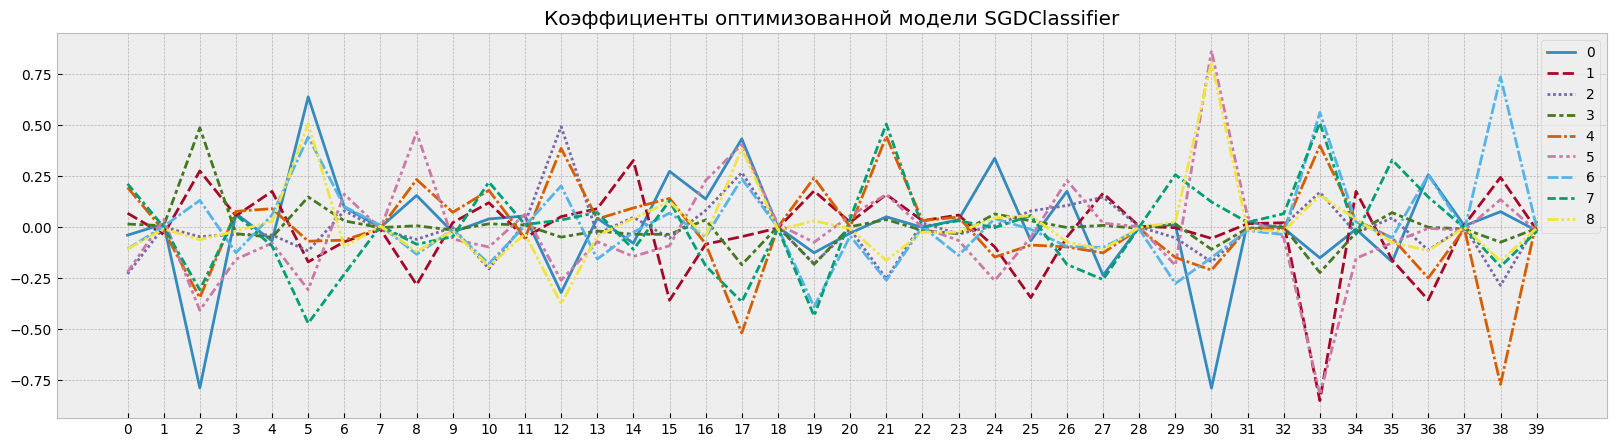

In [120]:
sgd_coefs = pd.DataFrame(sgd_opt_model.coef_).T

plt.figure(figsize=(20, 5))
sns.lineplot(sgd_coefs)

plt.xticks(sgd_coefs.index)
plt.title('Коэффициенты оптимизованной модели SGDClassifier')
plt.show()

# <center> **SUBMISSION**

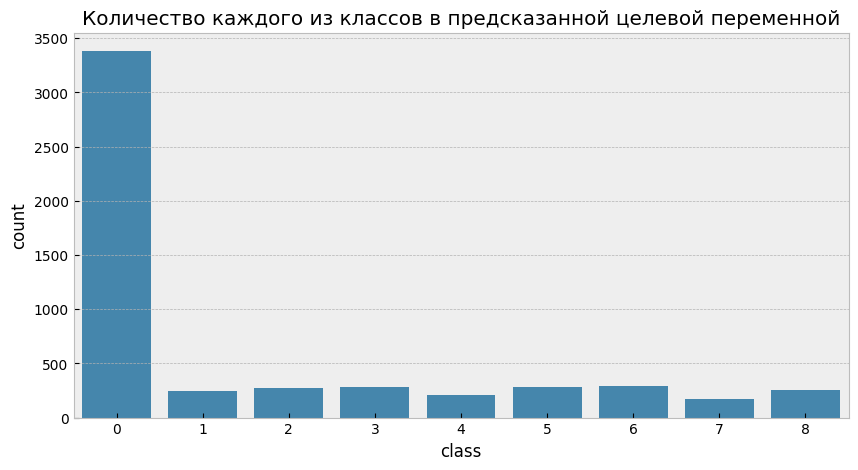

In [115]:
y_test['class'] = sgd_opt_model.predict(X_test_2d)
y_test.to_csv('data/y_test_predicted.csv', index=False)

plt.figure(figsize=(10, 5))
sns.barplot(y_test['class'].value_counts())

plt.title('Количество каждого из классов в предсказанной целевой переменной')
plt.show() 

Как видим, график очень похож на тот, что мы видели выше, когда смотрели на реальную целевую переменную. Значит модель хорошо справилась с задачей. Выведем ее на экран.

In [99]:
print(sgd_opt_model)

SGDClassifier(alpha=0.01, eta0=1, learning_rate='adaptive', n_jobs=-1,
              random_state=3)
